# 2017년 코트라 데이터 분석 

저희는 2018년 데이터 분석 및 모델링을 통해 가장 낮은 `RMSE`를 찾으며 분석과 모델링을 바탕으로 2019년 수입금액을 예측하였습니다. <br>

머신러닝 모델을 훈련하는 과정을 알아보면, 크게 단일 모델과 앙상블 모델로 나눌 수 습니다. <br>
 <br>`단일 모델`은 하나의 모델만 사용해 최종값을 도출하는 모델을 의미합니다. <br>

`앙상블 모델`은 여러 개의 모델을 적절하게 결합해 최종값을 도출하는 의미합니다. <br>

 <br>이번에는 주로 단일 모델의 조합으로 결과값을 내는 앙상블 모델을 사용해 일반화 `앙상블 모델` 학습법에는 `배깅(Bagging)과 부스팅(Boosting)`방식을 진행했습니다. <br>

 <br>`배깅(bagging)`과 `부스팅(boosting)`을 통해 변수를 선정하며 `A/B 테스트`를 통해 최적의 변수를 선정하였습니다.  
모델의 일반화 성능을 높이기 위해 `랜덤 포레스트(RandomForest)`를 주 모델로 선정하였습니다. 




## 2018년 수입 금액을 가장 잘 예측하는 모델링 선정하기




## INDEX


### 1. 모듈 및 데이터 로드

### 2. 모델 구축
#### 2.1 모델링 전 변수 정리 및 피처 스케일링

- -`Y 변수`는 `로그스케일링` `나머지 변수`는 `standard_scalling`

### 3. 변수 선택 및 하이퍼파라미터 튜닝

#### 3.1 변수 선택과 `A/B테스트`
- - `RandomForestRegressor(random_state=1217)`을 모델로 지정하고, A-Z의 변수 중에서서 A,B를 기본 변수로 설정
- -추가 변수들 `A/B 테스트`
- -lightgbm, xgb_model 동일하게 시행

#### 3.2 하이퍼파라미터 튜닝 
- -`그리드 탐색`
- -`임의 탐색`

#### 3.3 Sumbission csv만들기

### 4.최종  모델 구축

- - `RandomForestRegressor`,  `Lightgbm`, `Xgb_model`의 `A/B 테스트`를 통한 변수들을 다시 모델링 최소 RMSE확인 

#### 4.1 첫 번째 데이터 사용

- - 첫 번째 모델은 `LightGBM 모델`로, 모델 학습에 `첫 번째 데이터`를 사용
- - 데이터 추가 및 이상치 제거 후
- - `RMSE = 1.54093`

- -두 번째 모델은 `RandomForestRegressor`, 첫 번째 데이터 사용
- -두 번째 모델은 랜덤포레스트 모델로, 모델 학습에 첫 번째 데이터 사용 
- -`RMSE = 0.7160`
- - 변수 추가 및 이상치 제거 후
- - `RMSE = 0.69210`

- 세 번째 모델 역시 `RandomForestRegressor`모델, 모델 학습에 첫 번째 데이터를 사용 
- `RMSE 1.1650`

- 변수 추가 및 이상치 제거 후
- RMSE = 1.101616

#### 4.2 두 번째 데이터로 만든 모델
- 네 번째 모델은 `RandomForestRegressor`모델 , 모델 학습은 두 번째 데이터를 사용 

- `RMSE 0.9956`

- 변수 추가 및 이상치 제거 후
- RMSE = 1.22759

#### 4.3 세 번째 데이터로 만든 모델 
- 다섯 번째 모델은 `RandomForestRegressor`로, 모델 학습에 세 번째 데이터를 사용
- `RMSE =1.2361`

- 변수 추가 및 이상치 제거 후
- `RMSE = 1.296439018`

### 5.정답 데이터셋 비교




# 1. 모듈 및 데이터 로드

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

#내부에 결과를 출력하도록 설정

%matplotlib inline 

#시각화 한글 폰트 설정
#맥 사용자
plt.rc('font', family ='AppleGothic')

#마이너스 기호 출력
plt.rc('axes', unicode_minus=False)

#분석에 문제가 없는 경고 메세지는 숨긴다.
import warnings 
warnings.filterwarnings('ignore')

In [2]:
train_all = pd.read_csv('공모전데이터_분석용_KOTRA_0525.csv')
test = pd.read_csv('공모전데이터_예측용_KOTRA_0525.csv')

In [3]:
train6 = pd.read_csv('train6.csv')

In [4]:
#학습 데이터 복사본 생성
train = train6.copy()

In [5]:
#매출액이 0 이상인 행 출력
train = train[train['KR_TRADE_HSCD_COUNTRYCD']>0]

# 2. 모델 구축

In [6]:
#문자 형태의 변수 추출
object_column = list(train.columns[train.dtypes=='object'])
#문자형 변수 제거 
train = train.drop(object_column, axis='columns')


### 필요 없는 변수 정리

In [7]:
train.drop(['UNC_YEAR'],axis=1, inplace=True)

In [8]:
train.drop(['COUNTRYCD'],axis=1, inplace=True)

In [9]:
train.drop(['17LCL_diff'],axis=1, inplace=True)

### 피처 스케일링

In [10]:
#스케일링 작업 같은 범위로 압축 
# 피처 각각에 대한 scaling을 수행하는 함수를 정의합니다.
def standard_scaling(df, scale_columns):
    for col in scale_columns:
        series_mean = df[col].mean()
        series_std = df[col].std()
        df[col] = df[col].apply(lambda x: (x-series_mean)/series_std)
    return df

#컨셉은 '각각의 평균을 표준편차로 나눈 값은 수렴한다'라고 생각됩니다.
#확률과 통계에서 자주 나오는 표준편차와 분산은 보통 -1~+1 사이에서 분포한다는 점과 연관하여 생각해보았습니다.

- 스케일링 필요 없는 변수


- gdp_diff
- country_depend
- 17FCL_diff                                
- 17EMPTY_diff                
- 17Total_diff
- 17hang_diff
- 17fl_diff
- TRADE_HSCD_COUNTRYCD_ratio
- 'FTA',
- 'OECD',
- 'WTO',
- 'ASEM',
- 'ASEAN',
- 'FEALAC',
- 'HSCD'

In [11]:
# 피처 각각에 대한 scaling을 수행합니다.
scale_columns = [
    #'HSCD',
 'TRADE_COUNTRYCD',
 'TRADE_HSCD',
 'TARIFF_AVG',
 'SNDIST',
 'NY_GDP_MKTP_CD',
 'NY_GDP_MKTP_CD_1Y',
 'SP_POP_TOTL',
 'PA_NUS_FCRF',
 'IC_BUS_EASE_DFRN_DB',
 'KMDIST',
 #'gdp_diff',
 '1_gdp',
 'item_depend',
 #'country_depend',
 'item_md_rv',
 'sndist_mean',
 'TRADE_HSCD_COUNTRYCD',
 #'FTA',
 #'OECD',
 #'WTO',
 #'ASEM',
 #'ASEAN',
 #'FEALAC',
 '2017_FCL',
 '2017_LCL',
 '2017_EMPTY',
 '2017_Total',
 '2018_FCL',
 '2018_LCL',
 '2018_EMPTY',
 '2018_Total',
 #'17FCL_diff',
 #'17EMPTY_diff',
 #'17Total_diff',
 '2016_hang',
 '2017_hang',
 #'17hang_diff',
 '2016_lpi',
 '2016_fl',
 '2017_fl',
 #'17fl_diff',
 'TARIFF_AVG_sum',
 'TRADE_HSCD_COUNTRYCD_mean',
 'TARIFF_AVG_mean',
 'TRADE_HSCD_COUNTRYCD_sum'  
 #'TRADE_HSCD_COUNTRYCD_ratio'
    
]
picher_df = standard_scaling(train, scale_columns)
picher_df


,HSCD,TRADE_COUNTRYCD,TRADE_HSCD,TARIFF_AVG,SNDIST,NY_GDP_MKTP_CD,NY_GDP_MKTP_CD_1Y,SP_POP_TOTL,PA_NUS_FCRF,IC_BUS_EASE_DFRN_DB,...,17hang_diff,2016_lpi,2016_fl,2017_fl,17fl_diff,TARIFF_AVG_sum,TRADE_HSCD_COUNTRYCD_sum,TARIFF_AVG_mean,TRADE_HSCD_COUNTRYCD_mean,TRADE_HSCD_COUNTRYCD_ratio
0,1,-0.647468,0.461466,2.981455e+00,-0.966606,-0.423601,-0.420734,-0.257087,-0.271019,-2.253847,...,-0.216323,-1.336198,-0.700911,-0.712614,0.148799,1.633474,0.906779,1.759292e+00,1.287454,0.001041
1,1,-0.352168,0.461466,1.633334e+00,1.265862,0.354606,0.292919,0.365996,-0.288115,-1.385166,...,0.039413,-0.688732,-0.316806,-0.301233,0.147121,1.633474,0.906779,1.759292e+00,1.287454,0.009544
2,1,-0.723058,0.461466,1.728690e-01,-0.187049,-0.465219,-0.461227,-0.212190,-0.072854,-2.575967,...,0.169344,-1.969040,-0.705165,-0.717413,-0.045674,1.633474,0.906779,1.759292e+00,1.287454,0.003888
3,1,-0.717240,0.461466,2.981455e+00,-0.076841,-0.457620,-0.454588,-0.331752,-0.264441,-0.969091,...,0.117117,0.043091,-0.602716,-0.622810,-0.011418,1.633474,0.906779,1.759292e+00,1.287454,0.000256
4,1,-0.593302,0.461466,-3.888481e-01,1.229503,-0.379655,-0.381273,-0.342884,-0.185709,0.132441,...,0.064247,-0.362340,-0.335494,-0.421058,-0.141039,1.633474,0.906779,1.759292e+00,1.287454,0.013014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18174,1,-0.543171,0.409029,4.989050e-16,0.782803,-0.349841,-0.361240,-0.198647,-0.286508,-0.446049,...,0.048163,0.709400,-0.508972,-0.518298,0.086119,-1.770828,0.570976,3.044318e-15,1.138883,0.006697
18175,1,0.212425,0.409029,4.989050e-16,-0.338904,0.046109,0.047012,-0.237606,-0.288440,0.699118,...,0.069449,0.611947,-0.431522,-0.459349,0.009805,-1.770828,0.570976,3.044318e-15,1.138883,0.105062
18176,1,-0.022864,0.409029,4.989050e-16,-0.794252,-0.213992,-0.197649,-0.380388,-0.288465,0.585778,...,-0.003818,1.140304,-0.311934,-0.338531,0.031702,-1.770828,0.570976,3.044318e-15,1.138883,0.064508
18177,1,-0.013124,0.409029,4.989050e-16,-0.283228,-0.335018,-0.334762,-0.376512,-0.288038,0.680718,...,-0.062945,1.047973,3.447701,3.274783,0.029579,-1.770828,0.570976,3.044318e-15,1.138883,0.070491


In [12]:
#컬럼명 추출
train.columns.tolist()

['HSCD',
 'TRADE_COUNTRYCD',
 'TRADE_HSCD',
 'TARIFF_AVG',
 'SNDIST',
 'NY_GDP_MKTP_CD',
 'NY_GDP_MKTP_CD_1Y',
 'SP_POP_TOTL',
 'PA_NUS_FCRF',
 'IC_BUS_EASE_DFRN_DB',
 'KMDIST',
 'TRADE_HSCD_COUNTRYCD',
 'KR_TRADE_HSCD_COUNTRYCD',
 'gdp_diff',
 '1_gdp',
 'item_depend',
 'country_depend',
 'item_md_rv',
 'sndist_mean',
 'FTA',
 'OECD',
 'WTO',
 'ASEM',
 'ASEAN',
 'FEALAC',
 '2017_FCL',
 '2017_LCL',
 '2017_EMPTY',
 '2017_Total',
 '2018_FCL',
 '2018_LCL',
 '2018_EMPTY',
 '2018_Total',
 '17FCL_diff',
 '17EMPTY_diff',
 '17Total_diff',
 '2016_hang',
 '2017_hang',
 '17hang_diff',
 '2016_lpi',
 '2016_fl',
 '2017_fl',
 '17fl_diff',
 'TARIFF_AVG_sum',
 'TRADE_HSCD_COUNTRYCD_sum',
 'TARIFF_AVG_mean',
 'TRADE_HSCD_COUNTRYCD_mean',
 'TRADE_HSCD_COUNTRYCD_ratio']

### Y(종속변수) 로그 변환
- 독립변수와 다르게 종속변수의 경우는 정규성을 더욱 보장하는 로그변환을 통해 스케일링 진행

In [13]:
#로그함수로 치환
train["KR_TRADE_HSCD_COUNTRYCD"] = np.log1p(train["KR_TRADE_HSCD_COUNTRYCD"]) 


In [14]:
train[['KR_TRADE_HSCD_COUNTRYCD']]

,KR_TRADE_HSCD_COUNTRYCD
0,8.943506
1,11.718728
2,13.355193
3,10.710811
4,11.062191
...,...
18174,12.842335
18175,15.782035
18176,14.753594
18177,13.689057


In [15]:
train_all

,UNC_YEAR,HSCD,COUNTRYCD,COUNTRYNM,TRADE_COUNTRYCD,TRADE_HSCD,TARIFF_AVG,SNDIST,NY_GDP_MKTP_CD,NY_GDP_MKTP_CD_1Y,SP_POP_TOTL,PA_NUS_FCRF,IC_BUS_EASE_DFRN_DB,KMDIST,TRADE_HSCD_COUNTRYCD,KR_TRADE_HSCD_COUNTRYCD
0,2017,190590,12,Algeria,46052990973,19480986257,30.0,3878.238437,170163165961,159994837855,41389198,110.973017,46.109810,9954.009766,3.416326e+06,7657
1,2017,190590,36,Australia,228441691195,19480986257,0.0,12203.155980,1329188475752,1208846993740,24601860,1.304758,80.223690,8329.652344,4.387470e+08,5294788
2,2017,190590,40,Austria,166475020975,19480986257,0.0,4403.247293,417237869116,395568644341,8797566,NaN,78.856460,8289.029297,4.532064e+08,335818
3,2017,190590,56,Belgium,406412223480,19480986257,0.0,3980.375563,502698069367,475739588765,11375158,NaN,72.409200,8722.114258,7.065245e+08,173709
4,2017,190590,76,Brazil,150749493921,19480986257,18.0,9644.206941,2062831045936,1795700168991,207833831,3.191389,55.382403,18364.505860,3.132965e+07,122850
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21184,2017,852852,784,United Arab Emirates,270954907547,18327708223,NaN,5643.250737,385605506855,357045064670,9487203,3.672500,77.434350,6909.236328,2.056493e+08,881214
21185,2017,852852,792,Turkey,233799651234,18327708223,NaN,4123.461111,858988610574,869683121563,81101892,3.648133,69.378820,7967.700684,1.330809e+08,9545535
21186,2017,852852,818,Egypt,66338749061,18327708223,NaN,NaN,235733695652,332441717791,96442593,17.782534,55.474280,8497.368164,NaN,1313545
21187,2017,852852,826,United Kingdom,641332371112,18327708223,NaN,4071.487776,2666229179958,2694283209613,66058859,0.776977,83.341080,8875.389648,1.142794e+09,19876811


In [16]:
picher_df

,HSCD,TRADE_COUNTRYCD,TRADE_HSCD,TARIFF_AVG,SNDIST,NY_GDP_MKTP_CD,NY_GDP_MKTP_CD_1Y,SP_POP_TOTL,PA_NUS_FCRF,IC_BUS_EASE_DFRN_DB,...,17hang_diff,2016_lpi,2016_fl,2017_fl,17fl_diff,TARIFF_AVG_sum,TRADE_HSCD_COUNTRYCD_sum,TARIFF_AVG_mean,TRADE_HSCD_COUNTRYCD_mean,TRADE_HSCD_COUNTRYCD_ratio
0,1,-0.647468,0.461466,2.981455e+00,-0.966606,-0.423601,-0.420734,-0.257087,-0.271019,-2.253847,...,-0.216323,-1.336198,-0.700911,-0.712614,0.148799,1.633474,0.906779,1.759292e+00,1.287454,0.001041
1,1,-0.352168,0.461466,1.633334e+00,1.265862,0.354606,0.292919,0.365996,-0.288115,-1.385166,...,0.039413,-0.688732,-0.316806,-0.301233,0.147121,1.633474,0.906779,1.759292e+00,1.287454,0.009544
2,1,-0.723058,0.461466,1.728690e-01,-0.187049,-0.465219,-0.461227,-0.212190,-0.072854,-2.575967,...,0.169344,-1.969040,-0.705165,-0.717413,-0.045674,1.633474,0.906779,1.759292e+00,1.287454,0.003888
3,1,-0.717240,0.461466,2.981455e+00,-0.076841,-0.457620,-0.454588,-0.331752,-0.264441,-0.969091,...,0.117117,0.043091,-0.602716,-0.622810,-0.011418,1.633474,0.906779,1.759292e+00,1.287454,0.000256
4,1,-0.593302,0.461466,-3.888481e-01,1.229503,-0.379655,-0.381273,-0.342884,-0.185709,0.132441,...,0.064247,-0.362340,-0.335494,-0.421058,-0.141039,1.633474,0.906779,1.759292e+00,1.287454,0.013014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18174,1,-0.543171,0.409029,4.989050e-16,0.782803,-0.349841,-0.361240,-0.198647,-0.286508,-0.446049,...,0.048163,0.709400,-0.508972,-0.518298,0.086119,-1.770828,0.570976,3.044318e-15,1.138883,0.006697
18175,1,0.212425,0.409029,4.989050e-16,-0.338904,0.046109,0.047012,-0.237606,-0.288440,0.699118,...,0.069449,0.611947,-0.431522,-0.459349,0.009805,-1.770828,0.570976,3.044318e-15,1.138883,0.105062
18176,1,-0.022864,0.409029,4.989050e-16,-0.794252,-0.213992,-0.197649,-0.380388,-0.288465,0.585778,...,-0.003818,1.140304,-0.311934,-0.338531,0.031702,-1.770828,0.570976,3.044318e-15,1.138883,0.064508
18177,1,-0.013124,0.409029,4.989050e-16,-0.283228,-0.335018,-0.334762,-0.376512,-0.288038,0.680718,...,-0.062945,1.047973,3.447701,3.274783,0.029579,-1.770828,0.570976,3.044318e-15,1.138883,0.070491


In [16]:
X_train=train.drop([
#'HSCD',
 #'TRADE_COUNTRYCD',
 'TRADE_HSCD',
 'TARIFF_AVG',
 'SNDIST',
 #'NY_GDP_MKTP_CD',
 #'NY_GDP_MKTP_CD_1Y',
 #'SP_POP_TOTL',
 #'PA_NUS_FCRF',
 #'IC_BUS_EASE_DFRN_DB',
 #'KMDIST',
 'KR_TRADE_HSCD_COUNTRYCD',
 #'gdp_diff',
 #'1_gdp',
 #'item_depend',
 #'country_depend',
 #'item_md_rv',
 #'sndist_mean',
 #'TRADE_HSCD_COUNTRYCD',
 #'FTA',
 #'OECD',
 #'WTO',
 'ASEM',
 #'ASEAN',
 #'FEALAC',
 #'2017_FCL',
 '2017_LCL',
 '2017_EMPTY',
 '2017_Total',
 #'2018_FCL',
 '2018_LCL',
 '2018_EMPTY',
 #'2018_Total',
 '17FCL_diff',
 #'17EMPTY_diff',
 '17Total_diff',
 '2016_hang',
 '2017_hang',
 '17hang_diff',
 #'2016_lpi',
 '2016_fl',
 '2017_fl',
 '17fl_diff',
 #'TARIFF_AVG_sum',
 #'TRADE_HSCD_COUNTRYCD_sum',
 #'TARIFF_AVG_mean',
 #'TRADE_HSCD_COUNTRYCD_mean',
 #'TRADE_HSCD_COUNTRYCD_ratio'
],axis='columns')

X_test =train.drop([
#'HSCD',
 #'TRADE_COUNTRYCD',
 'TRADE_HSCD',
 'TARIFF_AVG',
 'SNDIST',
 #'NY_GDP_MKTP_CD',
 #'NY_GDP_MKTP_CD_1Y',
 #'SP_POP_TOTL',
 #'PA_NUS_FCRF',
 #'IC_BUS_EASE_DFRN_DB',
 #'KMDIST',
 'KR_TRADE_HSCD_COUNTRYCD',
 #'gdp_diff',
 #'1_gdp',
 #'item_depend',
 #'country_depend',
 #'item_md_rv',
 #'sndist_mean',
 #'TRADE_HSCD_COUNTRYCD',
 #'FTA',
 #'OECD',
 #'WTO',
 'ASEM',
 #'ASEAN',
 #'FEALAC',
 #'2017_FCL',
 '2017_LCL',
 '2017_EMPTY',
 '2017_Total',
 #'2018_FCL',
 '2018_LCL',
 '2018_EMPTY',
 #'2018_Total',
 '17FCL_diff',
 #'17EMPTY_diff',
 '17Total_diff',
 '2016_hang',
 '2017_hang',
 '17hang_diff',
 #'2016_lpi',
 '2016_fl',
 '2017_fl',
 '17fl_diff',
 #'TARIFF_AVG_sum',
 #'TRADE_HSCD_COUNTRYCD_sum',
 #'TARIFF_AVG_mean',
 #'TRADE_HSCD_COUNTRYCD_mean',
 #'TRADE_HSCD_COUNTRYCD_ratio'
],axis='columns')

y_train = train['KR_TRADE_HSCD_COUNTRYCD']

# 3. 변수 선택 및 하이퍼 파라미터 튜닝

## 변수 선택
- 새로운 변수를 추가할 때나 고차원 데이터를 사용할 때 유용한 변수만 선택하고 나머지는 제거해 변수의 수를 줄이는 과정
- 유용한 변수를 찾는 방법으로 일반화 성능을 높일 수 있음
- 변수를 선택하는 여러 방법 중 기본 트리 모델을 가지고 변수들을 하나씩 넣고 제거하면서 변수들의 조합을 찾는 A/B테스트를 주로 활용

- A/B테스트 활용한 변수 선택

1.트리 계열 모델과 기본 변수를 설정해주기
- RandomForestRegressor(random_state=1217)(이하 RF라고 칭함)을 모델로 지정하고, A-Z의 변수 중에서서 A,B를 기본 변수로 설정

2.기본 변수만 가지고 설정한 모델의 성능을 확인
- A,B만을 변수로 가진 RF의 성능을 교차검증을 통해 확인해본 결과 RMSE 기준으로 2.11정도 확인

3.기본 변수에 하나씩 변수를 추가해 성능이 향상된다면 그대로두고, 향상되지 않는다면 제거, 이과정을 반복하여 변수를 선택
- A,B,C를 변수로 가진 RF의 성능을 확인해 보니 RMSE 값이 2.11보다 낮아져 성능이 향상, 성능 향상 됐으니 C변수 그대로 두기
- A,B,C,D를 변수로 가진 RF의 성능을 확인해 보니 RMSE 값이 2.11보다 높아져 성능이 저하, 성능이 저하됐으니 D라는 변수 제거 
- A,B,C,E를 변수로 가진 RF의 성능을 확인해보니 RMSE 값이 2.11보다 낮아져 성능이 향상, 성능이 향상됐으니 E라는 변수는 그대로 두기
- 위와 같이 A/B 테스트를 반복하여 변수 선택 (RF, LGBM, XGBM 모두 시행 )

In [18]:
import lightgbm as lgb

#LGBMegressor 메서드 저장
lgbm = lgb.LGBMRegressor(random_state=1217)
#모델 학습
lgbm.fit(X_train, y_train)
#예측값 생성
y_test = lgbm.predict(X_test)

In [19]:
#LGBM교차검증
from sklearn.model_selection import cross_val_score
lgbm = lgb.LGBMRegressor(random_state=1217)
#cv=5인 교차검증
scores = cross_val_score(lgbm, X_train, y_train, cv=5, n_jobs= -1,
                        scoring = 'neg_mean_squared_error')

#성능 확인
print('cross_val_score \n{}'.format(np.sqrt(-scores)))
print('cross_val_score.mean \n{:.3f}'.format(np.sqrt(-scores.mean())))

cross_val_score 
[2.19209051 1.89550458 1.98219583 1.94619048 1.93485633]
cross_val_score.mean 
1.993


In [322]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor(random_state=1217)
#모델 학습
xgb_model.fit(X_train , y_train)
#예측값 생성
y_test=xgb_model.predict(X_test)

In [323]:
#xgb_model교차검증
from sklearn.model_selection import cross_val_score
xgb_model = XGBRegressor(random_state=1217)
#cv=5인 교차검증
scores = cross_val_score(xgb_model, X_train, y_train, cv=5, n_jobs= -1,
                        scoring = 'neg_mean_squared_error')

#성능 확인
print('cross_val_score \n{}'.format(np.sqrt(-scores)))
print('cross_val_score.mean \n{:.3f}'.format(np.sqrt(-scores.mean())))

cross_val_score 
[2.22803928 1.99825775 2.0957957  1.97280493 2.0021496 ]
cross_val_score.mean 
2.062


In [17]:
from sklearn.ensemble import RandomForestRegressor


#RandomForestRegressor 메서드 저장
rf_model = RandomForestRegressor(random_state = 1217)
#모델학습
rf_model.fit(X_train, y_train)
#예측값 생성
y_test = rf_model.predict(X_test)

In [21]:
#랜덤포레스트 교차검증
from sklearn.model_selection import cross_val_score
rf_model =RandomForestRegressor(random_state=1217)
#cv=5인 교차검증
scores = cross_val_score(rf_model, X_train, y_train, cv=5, n_jobs= -1,
                        scoring = 'neg_mean_squared_error')

#성능 확인
print('cross_val_score \n{}'.format(np.sqrt(-scores)))
print('cross_val_score.mean \n{:.3f}'.format(np.sqrt(-scores.mean())))

cross_val_score 
[2.19922873 1.92116515 2.03993678 1.97498749 1.9446179 ]
cross_val_score.mean 
2.018


In [18]:
#RF
input_var1 = [    
 'HSCD',
 'TRADE_COUNTRYCD',
 'NY_GDP_MKTP_CD',
 'NY_GDP_MKTP_CD_1Y',
 'SP_POP_TOTL',
 'PA_NUS_FCRF',
 'IC_BUS_EASE_DFRN_DB',
 'KMDIST',
 'gdp_diff',
 '1_gdp',
 'item_depend',
 'country_depend',
 'item_md_rv',
 'sndist_mean',
 'TRADE_HSCD_COUNTRYCD',
 'FTA',
 'OECD',
 'WTO',
 'ASEAN',
 'FEALAC',
 '2017_FCL',
 '2018_FCL',
 '2018_Total',
 '17EMPTY_diff',
 '2016_lpi',
 'TARIFF_AVG_sum',
 'TRADE_HSCD_COUNTRYCD_sum',
 'TARIFF_AVG_mean',
 'TRADE_HSCD_COUNTRYCD_mean',
 'TRADE_HSCD_COUNTRYCD_ratio']

In [324]:
#XGB
input_var2=[
 'HSCD',
 'TRADE_COUNTRYCD',
 'NY_GDP_MKTP_CD',
 'NY_GDP_MKTP_CD_1Y',
 'SP_POP_TOTL',
 'PA_NUS_FCRF',
 'IC_BUS_EASE_DFRN_DB',
 'KMDIST',
 'gdp_diff',
 '1_gdp',
 'item_depend',
 'country_depend',
 'WTO',
 'ASEAN',
 'FEALAC',
]

In [506]:
#LGBM
input_var3=[
'HSCD',
'TRADE_COUNTRYCD',
 'TRADE_HSCD',
 'TARIFF_AVG',
 'SNDIST',
 'NY_GDP_MKTP_CD',
 'NY_GDP_MKTP_CD_1Y',
 'IC_BUS_EASE_DFRN_DB',
 'KMDIST',
 'item_depend',
 'country_depend',
 'item_md_rv',
 'sndist_mean',
 'TRADE_HSCD_COUNTRYCD',
 'FTA',
 'OECD',
 'ASEAN',
 'FEALAC',
 '2018_LCL',
 '17Total_diff'
]

## 하이퍼파라미터 튜닝 
### 그리드 탐색 

In [19]:
from sklearn.model_selection import GridSearchCV

rf= RandomForestRegressor(random_state = 1217)

params = { 'n_estimators' : [200,300, 500],
           'max_depth' : [5, 6, 8],
           'min_samples_leaf' : [1, 3, 5],
            }


#GridsearchCV를 이용해 최적의 하이퍼파라미터 탐색
grid_cv = GridSearchCV(rf, param_grid=params, cv=3, n_jobs=-1)

#학습진행
grid_cv.fit(X_train[input_var1], y_train)

#RandomForestClassifier 객체 생성 후 GridSearchCV 수행
#rf_clf = RandomForestClassifier(random_state = 0, n_jobs = -1)
#rand_cv=RandomizedSearchCV(rf, param_distributions=params, n_iter=10,
                          #cv=3, random_state=1217, n_jobs=-1)
#rand_cv.fit(X_train[input_var1],y_train)

#최적의 하이퍼파라미터 값과 성능 출력
print('최적 하이퍼파라미터:',grid_cv.best_params_)
print('최적 하이퍼파라미터의 성능(RMSE):{:.4f}'.format(np.sqrt(grid_cv.best_score_)))

#최적의 하이퍼파라미터 값과 성능 출력 
#print('최적 하이퍼파라미터: ', rand_cv.best_params_)
#print('최적 하이퍼파라미터의 성능(RMSE):{:.4f}'.format(np.sqrt(rand_cv.best_score_)))

최적 하이퍼파라미터: {'max_depth': 8, 'min_samples_leaf': 5, 'n_estimators': 300}
최적 하이퍼파라미터의 성능(RMSE):0.6657


### Feature importances Top 20만 확인해보기

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [50]:
#y값 int형 변환
y_train = y_train.astype('int32')

In [51]:
#y값 int형 변환
y_test = y_test.astype('int32')

In [55]:
#rf_clf 만들어 두기
rf_clf1 = RandomForestClassifier(n_estimators=300, max_depth=8, min_samples_leaf=8, \
                                min_samples_split=5, random_state=1217)

rf_clf1.fit(X_train, y_train)
pred = rf_clf1.predict(X_test)
print('예측 정확도:'.format(accuracy_score(y_test, pred)))

예측 정확도:


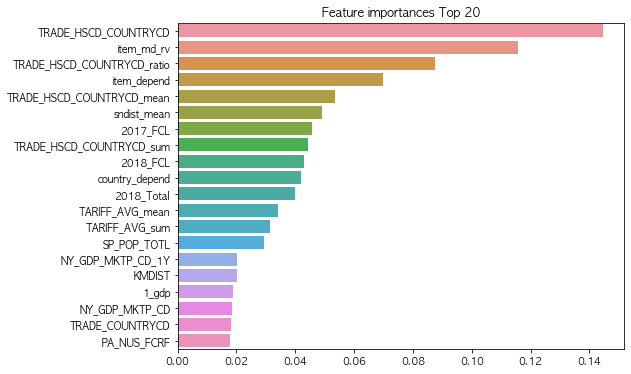

In [58]:
#중요한 피처 importances 출력
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

ftr_importances_values = rf_clf1.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index= X_train.columns )
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.title('Feature importances Top 20')
sns.barplot(x=ftr_top20, y=ftr_top20.index)
plt.show()

- 그리드탐색 max_features 8, min_samples_leaf 5, n_estimators 500으로 도출  RMSE 0.7376



- 변수 추가, 이상치 제거 후 다시 모델링
- 그리드 탐색 max_features 8, min_samples_leaf 5, n_estimators 300으로 도출  RMSE 0.6657

### 임의 탐색 

In [23]:
import scipy.stats as stats
from sklearn.model_selection import RandomizedSearchCV

rf= RandomForestRegressor(random_state=1217)

#탐색할 하이퍼파라미터 구간 지정
params = {'n_estimators':stats.randint(200,500),
         'max_features':stats.randint(4,8),
         'min_samples_leaf':stats.randint(1,5)}

#randomizedsearchCV를 이용해 최적의 하이퍼파라미터 탐색 
rand_cv=RandomizedSearchCV(rf, param_distributions=params, n_iter=10,
                          cv=3, random_state=1217, n_jobs=-1)
rand_cv.fit(X_train[input_var1],y_train)

#최적의 하이퍼파라미터 값과 성능 출력 
print('최적 하이퍼파라미터: ', rand_cv.best_params_)
print('최적 하이퍼파라미터의 성능(RMSE):{:.4f}'.format(np.sqrt(rand_cv.best_score_)))

최적 하이퍼파라미터:  {'max_features': 4, 'min_samples_leaf': 4, 'n_estimators': 436}
최적 하이퍼파라미터의 성능(RMSE):0.6657


- 임의탐색 max_features 4, min_samples_leaf 4, n_estimators 436으로 도출  RMSE 0.7682


- 변수 추가, 이상치 제거 후 다시 모델링
- 그리드 탐색 max_features 4, min_samples_leaf 4, n_estimators 436으로 도출  RMSE 0.6657

## Submission csv 만들기

In [471]:
sumbmission =train[['KR_TRADE_HSCD_COUNTRYCD']]

In [482]:
sumbmission =sumbmission[0:18180]

In [483]:
sumbmission[:]=0

In [485]:
sumbmission.to_csv('sumbmission_sample.csv',index=False)

In [489]:
sub = pd.read_csv('sumbmission_sample.csv')

# 4. 최종 모델 구축

## 첫 번째 데이터로 만든 모델
- 첫 번째 모델은 LightGBM 모델로, 모델 학습에 첫 번째 데이터를 사용
- RMSE = 1.6514


- 데이터 추가 및 이상치 제거 후
- RMSE = 1.54093

In [476]:
#첫 번째 모델 정의
model1 = lgb.LGBMRegressor(random_state=1217, num_iterations=1000, learning_rate=0.05,
                          boosting='dart',Metric='regression_l2',n_jobs=-1)

#모델 학습
model1.fit(X_train[input_var1], y_train)

#예측값 생성
pred1 = model1.predict(X_train[input_var1])

#성능 확인
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(y_train, pred1))

[LightGBM] [Warning] Unknown parameter: Metric
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


1.5409318023896852

In [491]:
#X_test 데이터에 대한 예측값 생성
y_pred1 = model1.predict(X_test[input_var1])
sub['KR_TRADE_HSCD_COUNTRYCD']=y_pred1

#submission csv 저장
sub.to_csv('model1f_lgbm.csv',index=False)

- 두 번째 모델은 랜덤포레스트 모델로, 모델 학습에 첫 번째 데이터 사용 
- RMSE = 0.7160



- 변수 추가 및 이상치 제거 후
- RMSE = 0.69210

In [497]:
#두 번째 모델 정의
model2 = RandomForestRegressor(random_state=1217, max_features=8,
                              min_samples_leaf=1, n_estimators=500, n_jobs=1)

#모델 학습
model2.fit(X_train[input_var1],y_train)
#예측값 생성
pred2 = model2.predict(X_train[input_var1])
#성능 확인
np.sqrt(mean_squared_error(y_train, pred2))

0.6921028526952316

In [494]:
#X_test 데이터에 대한 예측값 생성
y_pred2 = model2.predict(X_test[input_var1])
sub['KR_TRADE_HSCD_COUNTRYCD'] = y_pred2

#submission 폴더에 csv파일 젖
sub.to_csv('model2f_rf.csv',index=False)

- 세 번째 모델 역시 랜덤포레스트 모델, 모델 학습에 첫 번째 데이터를 사용 
- RMSE 1.1650




- 변수 추가 및 이상치 제거 후
- RMSE = 1.101616

In [501]:
#세번째 모델 정의 
model3 = RandomForestRegressor(random_state=1217, max_features=3,
                              min_samples_leaf=2, n_estimators=500, n_jobs=1)

#모델 학습
model3.fit(X_train[input_var1],y_train)
#예측값 생성
pred3 = model3.predict(X_train[input_var1])
#성능 확인
np.sqrt(mean_squared_error(y_train, pred3))

1.1016164366861116

In [502]:
#X_test 데이터에 대한 예측값 생성
y_pred3 = model3.predict(X_test[input_var1])
sub['KR_TRADE_HSCD_COUNTRYCD'] = y_pred3

#submission 폴더에 csv파일 젖
sub.to_csv('model3f_rf.csv',index=False)

## 두 번째 데이터로 만든 모델
- 네 번째 모델은 랜덤포레스트 모델 , 모델 학습은 두 번째 데이터를 사용 
- RMSE 0.9956



- 변수 추가 및 이상치 제거 후
- RMSE = 1.22759

In [504]:
#네 번째 모델 정의
model4 = RandomForestRegressor(random_state=1217, max_features=4,
                              min_samples_leaf=2, n_estimators=500, n_jobs=1)

#모델 학습
model4.fit(X_train[input_var2], y_train)
#예측값 생성
pred4 = model4.predict(X_train[input_var2])
#성능 확인
np.sqrt(mean_squared_error(y_train, pred4))

1.2275989630689035

In [505]:
#X_test 데이터에 대한 예측값 생성
y_pred4 = model4.predict(X_test[input_var2])
sub['KR_TRADE_HSCD_COUNTRYCD'] = y_pred4

#submission 폴더에 csv파일 저장
sub.to_csv('model4f_rf.csv',index=False)

## 세 번째 데이터로 만든 모델 
- 다섯 번째 모델은 랜덤포레스트 모델로, 모델 학습에 세 번째 데이터를 사용
- RMSE =1.2361


-------
- 변수 추가 및 이상치 제거 후
- RMSE = 1.296439018

In [508]:
#다섯 번째 모델 정의
model5 = RandomForestRegressor(random_state=1217, max_features=7,
                              min_samples_leaf=4, n_estimators=500, n_jobs=1)

#모델 학습
model5.fit(X_train[input_var3], y_train)
#예측값 생성
pred5 = model5.predict(X_train[input_var3])
#성능 확인
np.sqrt(mean_squared_error(y_train, pred5))

1.2964390180302285

In [509]:
#X_test 데이터에 대한 예측값 생성
y_pred5 = model5.predict(X_test[input_var3])
sub['KR_TRADE_HSCD_COUNTRYCD'] = y_pred5

#submission 폴더에 csv파일 젖
sub.to_csv('model5f_rf.csv',index=False)

# 5. 정답 데이터셋 비교 

In [513]:
model2f_rf = pd.read_csv('model2f_rf.csv')

In [510]:
train[['KR_TRADE_HSCD_COUNTRYCD']]

,KR_TRADE_HSCD_COUNTRYCD
0,8.943506
1,11.718728
2,13.355193
3,10.710811
4,11.062191
...,...
18174,12.842335
18175,15.782035
18176,14.753594
18177,13.689057


In [514]:
model2f_rf

,KR_TRADE_HSCD_COUNTRYCD
0,9.116131
1,11.982076
2,12.634160
3,9.908807
4,11.386033
...,...
18174,12.332944
18175,14.958567
18176,14.258636
18177,14.140867


### 원래 값으로 지수변환 비교

In [515]:
model2f_rf["KR_TRADE_HSCD_COUNTRYCD"] = np.expm1(model2f_rf["KR_TRADE_HSCD_COUNTRYCD"]) 

In [516]:
train["KR_TRADE_HSCD_COUNTRYCD"] = np.expm1(train["KR_TRADE_HSCD_COUNTRYCD"]) 

In [517]:
model2f_rf.head(100)

,KR_TRADE_HSCD_COUNTRYCD
0,9099.918443
1,159862.601300
2,306862.996122
3,20105.668885
4,88081.835706
...,...
95,25960.917466
96,413559.714698
97,79757.871294
98,327407.379592


In [519]:
train[['KR_TRADE_HSCD_COUNTRYCD']].head(100)

,KR_TRADE_HSCD_COUNTRYCD
0,7657.0
1,122850.0
2,631082.0
3,44837.0
4,63715.0
...,...
95,28777.0
96,622539.0
97,135963.0
98,240507.0
